In [ ]:
!pip install mplcyberpunk
!pip install python-bcb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.


In [ ]:
import mplcyberpunk
import seaborn as sns
import pandas as pd
from bcb import sgs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
from datetime import timedelta
plt.style.use("cyberpunk")

In [ ]:
import numpy as np
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

In [ ]:
df_inss = pd.read_csv('/content/drive/MyDrive/Dados/convenio_INSS.csv', sep=';')
df_inss['Data'] = pd.to_datetime(df_inss['Data'], format='%d/%m/%Y')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df_inss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       31 non-null     datetime64[ns]
 1   ValorBase  31 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 624.0+ bytes


In [ ]:
# Remover vírgula e converter coluna para float
df_inss['ValorBase'] = df_inss['ValorBase'].str.replace(',', '.').astype(float)

In [ ]:
df_inss.head(4)

,Data,ValorBase
0,2020-12-01,66416.00
1,2021-01-01,13667138.00
2,2021-02-01,16928081.00
3,2021-03-01,23783912.41


In [ ]:
df_inss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       31 non-null     datetime64[ns]
 1   ValorBase  31 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 624.0 bytes


#MODELO ARIMA INSS TREINO/TESTE

In [ ]:
train_size = int(len(df_inss.ValorBase) * 2 / 3)
train_size

20

In [ ]:
train_set = df_inss.ValorBase[:train_size]
test_set = df_inss.ValorBase[train_size:]

In [ ]:
train_set.shape, test_set.shape

((20,), (11,))

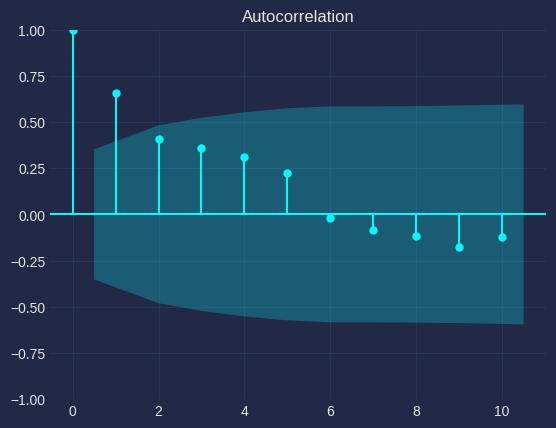

In [ ]:
plot_acf(df_inss.ValorBase, lags=10)
pyplot.show()

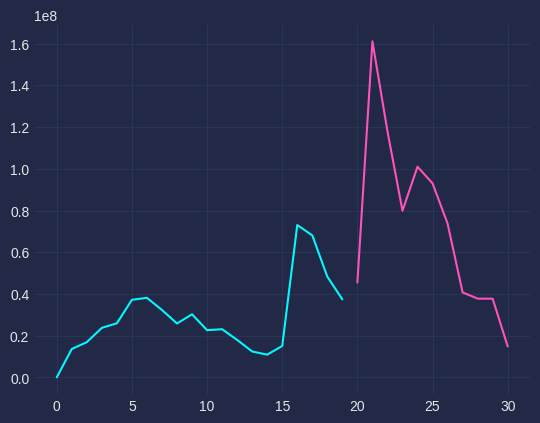

In [ ]:
plt.plot(train_set)
plt.plot(test_set)

In [ ]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg

ar_2 = AutoReg(train_set, lags=3).fit()
ar_2.params

const           1.987875e+07
ValorBase.L1    7.532745e-01
ValorBase.L2   -2.919411e-01
ValorBase.L3   -1.100138e-01
dtype: float64

In [ ]:
previsoes = ar_2.params[0] + test_set.shift(3) * ar_2.params[1] + test_set.shift(3) * ar_2.params[2]

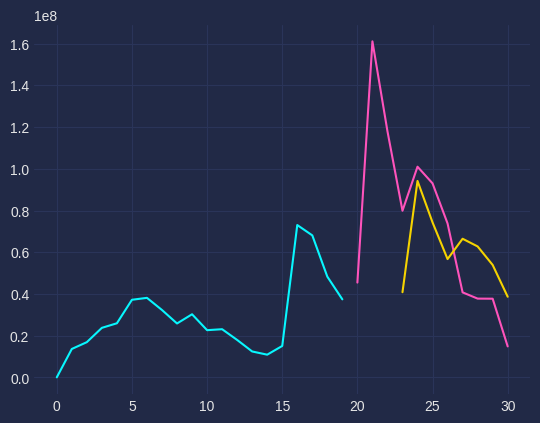

In [ ]:
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsoes)

In [ ]:
((test_set - previsoes) ** 2).mean()

540722812247737.5

# PREVISÕES SARIMAX CONVENIO GOVERNO

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Converter coluna de datas para o tipo datetime
df_inss['Data'] = pd.to_datetime(df_inss['Data'])

# Definir a coluna 'Data' como o índice do DataFrame
df_inss.set_index('Data', inplace=True)

In [ ]:
df_inss.tail(5)

,ValorBase
Data,
2023-02-01,73802960.26
2023-03-01,40782196.21
2023-04-01,37795073.09
2023-05-01,37751664.75
2023-06-01,14890228.63


In [ ]:
sarima = SARIMAX(df_inss.ValorBase, freq='MS', order=(1, 1, 1), seasonal_order=(2, 1, 2, 12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
print((sarima.resid).mean())

899476.0379649602


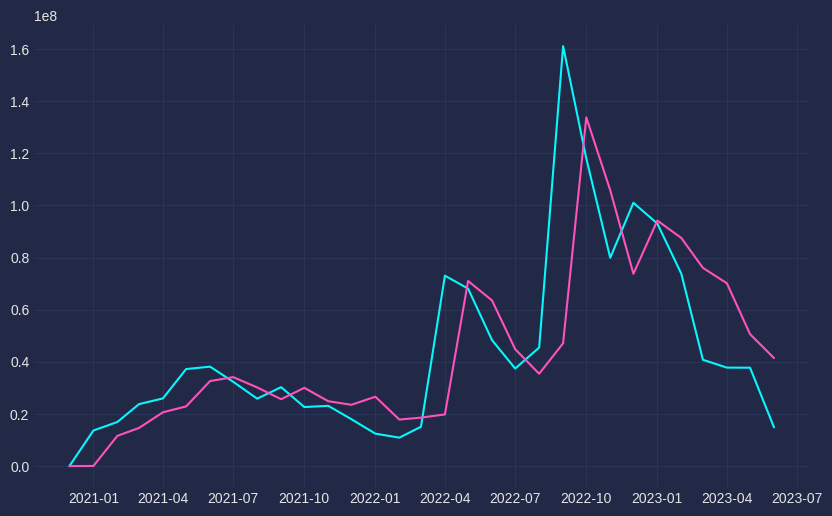

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_inss.ValorBase)
plt.plot(sarima.predict(typ='levels'))

In [ ]:
# Resultado da previsão

sarima.forecast()

2023-07-01    2.271829e+07
Freq: MS, dtype: float64

In [ ]:
df_inss.ValorBase.tail()

Data
2023-02-01    73802960.26
2023-03-01    40782196.21
2023-04-01    37795073.09
2023-05-01    37751664.75
2023-06-01    14890228.63
Name: ValorBase, dtype: float64

# PREVISÕES COM ARIMA CONVENIO INSS

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima = ARIMA(df_inss['ValorBase'], order=(3, 0, 3))
arima_fit = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Calcular o quadrado dos resíduos médios
mse = (arima_fit.resid ** 2).mean()
print(mse)

543327617335191.8


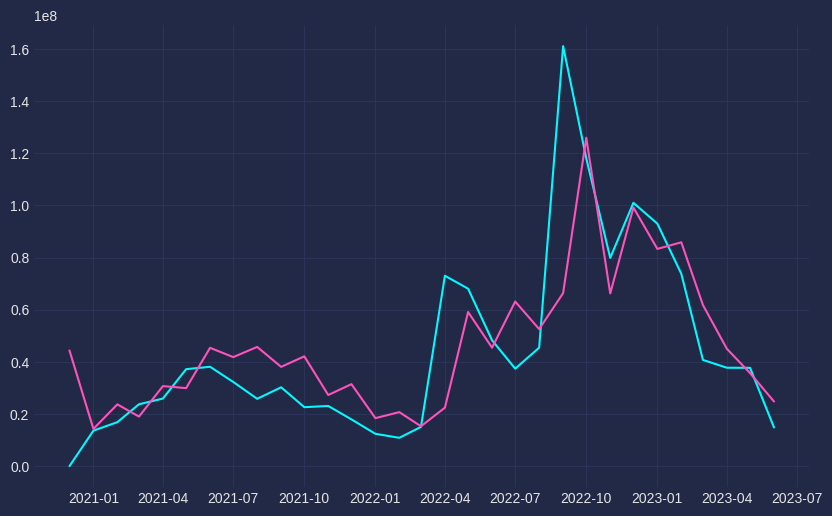

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_inss.ValorBase)
plt.plot(arima_fit.predict(typ='levels'))

In [ ]:
df_inss.tail(2)

,ValorBase
Data,
2023-05-01,37751664.75
2023-06-01,14890228.63


In [ ]:
# RESULTADO ARIMA
previsão = (arima_fit.forecast(steps=6).round())
arima_fit.forecast(steps=6).round()

2023-07-01     7501727.0
2023-08-01     9471322.0
2023-09-01     7830723.0
2023-10-01    13333177.0
2023-11-01    21555351.0
2023-12-01    31730132.0
Freq: MS, Name: predicted_mean, dtype: float64

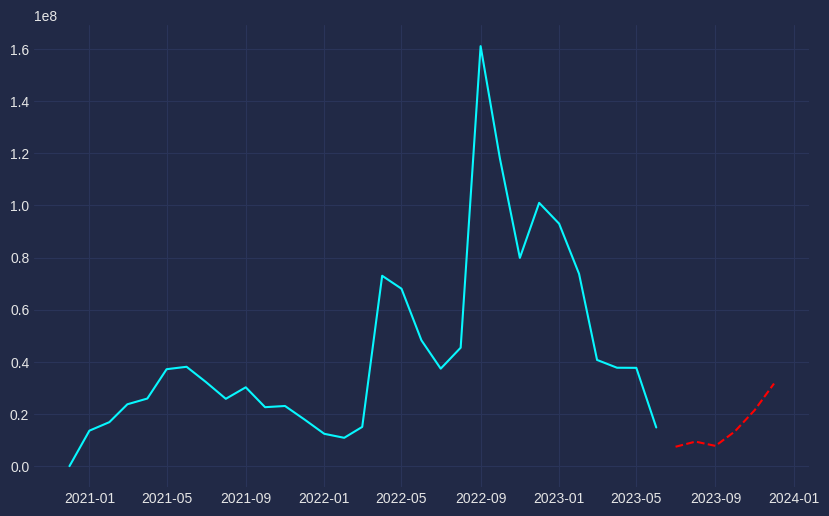

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_inss.ValorBase)
plt.plot(previsão, color='red', linestyle='--', label='Previsão')